In [377]:
# Module import section
import numpy as np
import pandas as pd
from os import path
from sodapy import Socrata
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import math
from scipy import stats

%matplotlib inline

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [372]:
# Set ipython's max row display
pd.set_option('display.max_row', 10000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

In [373]:
plt.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                    'xtick.color' : "white",
                    'ytick.color' : "white"})

In [374]:
# API pull section
nyc_domain = "data.cityofnewyork.us"
nyc_dataset_identifier = "43nn-pn8j"
nyc_client = Socrata(nyc_domain, None)
# In final version replace with limit = 396239
# Use 20000 otherwise
nyc_results = nyc_client.get(nyc_dataset_identifier, limit = 396239)
restdata = pd.DataFrame.from_dict(nyc_results)
print(restdata.shape)

(396077, 26)


In [444]:
# Data cleaning and enhancement cell
restdata['violation_description'] = restdata['violation_description'].fillna("")
restdata['action'] = restdata['action'].fillna("")
restdata['violation_code'] = restdata['violation_code'].fillna("")
# create a list of conditions
conditions = [
    (restdata['grade'] == 'A'),
    (restdata['grade'] == 'B'),
    (restdata['grade'] == 'C'),
    ((restdata['grade'] != 'A') & (restdata['grade'] != 'B') & (restdata['grade'] != 'C'))
    ]
# create a list of the values to assign for each condition
values = [3, 2, 1, 0]
# create a new column and use np.select to assign values to it using our lists as arguments
restdata['gradeval'] = np.select(conditions, values)
# display updated DataFrame
restdata.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,grade,grade_date,gradeval
0,50086106,PIZZA EXPRESS 2,Brooklyn,3005,AVENUE K,11210,7182532600,Jewish/Kosher,2019-03-04T00:00:00.000,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,15,2021-02-26T06:01:59.000,Pre-permit (Operational) / Initial Inspection,40.624404886364,-73.946245603165,318,45,074200,3207883,3076120008,BK58,NaN,NaN,0
1,41171181,169 BAR,Manhattan,169,EAST BROADWAY,10002,9175772077,American,2019-09-04T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,21,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,40.714072440996,-73.989813201259,103,01,000600,1003625,1002840026,MN28,NaN,NaN,0
2,40400539,ALL AMERICAN COFFEE SHOP,Queens,35-19,37 AVENUE,11101,7189376161,American,2019-12-30T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,13,2021-02-26T06:01:59.000,Cycle Inspection / Re-inspection,40.753154845794,-73.927809425352,401,26,005500,4009512,4006350001,QN68,A,2019-12-30T00:00:00.000,3
3,50080847,BAY SHISH KEBAB,Brooklyn,601,BRIGHTON BEACH AVENUE,11235,7189754455,Turkish,2020-02-13T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,32,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,40.577639799215,-73.961312663352,313,48,036200,3244921,3086760014,BK19,NaN,NaN,0
4,41590670,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,Manhattan,12,GRAND CENTRAL STATION,NaN,6464872003,"Caribbean (Inc. Cuban, Puerto Rican)",2019-09-30T00:00:00.000,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,9,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,0,0,NaN,NaN,NaN,NaN,1,NaN,A,2019-09-30T00:00:00.000,3


In [379]:
restdata[restdata['score'].notna()]['score'].astype(int)

0         15
1         21
2         13
3         32
4          9
          ..
396071    24
396072    11
396073    20
396074    38
396076     5
Name: score, Length: 377378, dtype: int64

In [380]:
restdata[restdata['grade']=='A']['score'].value_counts()

12    36869
13    29538
10    19132
11    18439
9     17089
7     13065
8      6426
5      5250
4      3845
2      3694
6      2696
3      1836
0       676
17        6
21        5
14        3
35        3
-1        2
33        2
23        1
Name: score, dtype: int64

Any time a field of what should be ints displays as floats, there are NaN values in the column.

In [381]:
restdata.cuisine_description.unique()

array(['Jewish/Kosher', 'American', 'Turkish',
       'Caribbean (Inc. Cuban, Puerto Rican)', 'Chinese', 'Italian',
       'Chicken', 'Pizza', 'Latin American (Central and South America)',
       'Café/Coffee/Tea', 'Mediterranean', 'Sandwiches', 'Mexican',
       'Hamburgers', 'Donuts', 'Eastern European', 'Russian',
       'Cakes, Cupcakes, Desserts', 'Korean', 'Spanish', 'Japanese',
       'Asian', 'Indian', 'Pancakes/Waffles',
       'Juice, Smoothies, Fruit Salads', 'Chinese/Cuban', 'French',
       'Sandwiches/Salads/Mixed Buffet', 'Irish',
       'Ice Cream, Gelato, Yogurt, Ices', 'Australian', 'Thai',
       'Peruvian', 'Other', 'Middle Eastern', 'African', 'Steak', 'Greek',
       'Brazilian', 'Vegetarian', 'Vietnamese/Cambodian/Malaysia',
       'Bagels/Pretzels', 'English', 'Tex-Mex', 'Salads',
       'Chinese/Japanese', 'Polish',
       'Bottled beverages, including water, sodas, juices, etc.',
       'Hawaiian', 'Bangladeshi', 'Scandinavian', 'Moroccan', 'Seafood',
       '

In [382]:
restdata.action.unique()

array(['Violations were cited in the following area(s).',
       'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.',
       'Establishment re-closed by DOHMH',
       'Establishment re-opened by DOHMH', '',
       'No violations were recorded at the time of this inspection.'],
      dtype=object)

In [383]:
restdata.violation_code.unique()

array(['06C', '10F', '02B', '08A', '04N', '04C', '04E', '09A', '10J',
       '06E', '04M', '22C', '09B', '10H', '10B', '02G', '06A', '02C',
       '04L', '06F', '06D', '09C', '04H', '05H', '20D', '20F', '10I',
       '02I', '08C', '03A', '22G', '02H', '04A', '16B', '', '05F', '05D',
       '22A', '15F6', '04J', '06B', '04K', '20E', '08B', '16E', '06G',
       '22F', '10D', '10A', '16C', '10E', '15A1', '15E2', '15L', '20A',
       '05E', '04D', '22E', '15F8', '05C', '15F1', '02A', '04O', '04F',
       '16A', '16D', '10C', '07A', '03C', '18G', '03B', '10G', '15F7',
       '05B', '05A', '18C', '18B', '06H', '02F', '03D', '02E', '18F',
       '15E3', '17A1', '15F2', '03G', '15I', '03E', '04B', '18D', '15T',
       '15K', '22B', '15J', '02D', '15S', '06I', '03F', '19A3', '04G',
       '19A1', '04I', '17A3', '02J', '15G7', '99B'], dtype=object)

In [384]:
restdata.violation_description.unique()

array(['Food not protected from potential source of contamination during storage, preparation, transportation, display or service.',
       'Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.',
       'Hot food item not held at or above 140º F.',
       'Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.',
       'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.',
       'Food worker does not use proper utensil to eliminate bare hand contact with food th

In [385]:
restdata.critical_flag.unique()

array(['Y', 'N', nan], dtype=object)

In [386]:
restdata.score.unique()

array(['15', '21', '13', '32', '9', '42', '8', '11', '17', '43', '12',
       '28', '7', '22', '26', '10', nan, '72', '19', '95', '4', '39',
       '40', '20', '16', '25', '33', '31', '53', '27', '38', '24', '2',
       '47', '59', '29', '49', '23', '46', '86', '41', '104', '61', '70',
       '18', '14', '44', '30', '-1', '51', '35', '48', '5', '3', '34',
       '54', '6', '36', '60', '50', '0', '65', '55', '37', '78', '56',
       '75', '98', '62', '79', '92', '66', '71', '74', '136', '97', '68',
       '52', '64', '58', '88', '57', '76', '45', '81', '63', '96', '80',
       '87', '83', '67', '85', '69', '120', '77', '89', '115', '102',
       '73', '84', '91', '90', '100', '99', '132', '107', '109', '94',
       '140', '82', '103', '119', '157', '110', '124', '101', '105',
       '111', '121', '93', '133', '164', '106', '117', '137', '122',
       '141', '116', '129', '114', '127', '153', '112', '151', '135',
       '150', '108'], dtype=object)

In [387]:
restdata.grade.unique()

array([nan, 'A', 'B', 'C', 'P', 'Z', 'N', 'G'], dtype=object)

In [388]:
restdata.inspection_type.unique()

array(['Pre-permit (Operational) / Initial Inspection',
       'Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Re-inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Cycle Inspection / Reopening Inspection',
       'Trans Fat / Initial Inspection',
       'Pre-permit (Operational) / Second Compliance Inspection',
       'Pre-permit (Operational) / Reopening Inspection', nan,
       'Inter-Agency Task Force / Initial Inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Smoke-Free Air Act / Re-inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Calorie Posting / Initial Inspection',
       'Trans Fat / Compliance Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Pre-permit (Non-operational) / Compliance Inspec

In [389]:
restdata.boro.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island', '0'],
      dtype=object)

In [390]:
restdata[restdata['boro'] == '0']

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,grade,grade_date,gradeval
265,50005134,KINFOLK,0,94,WYTHE AVE,11249,3477992946,American,2017-08-12T00:00:00.000,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,29,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2190,50064306,DYLAN'S CANDY BAR,0,2849,paces ferry rd,30339,7187514247,Other,2017-11-02T00:00:00.000,Violations were cited in the following area(s).,05H,"No facilities available to wash, rinse and san...",Y,28,2021-02-26T06:01:59.000,Pre-permit (Operational) / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2204,41539237,ENERGY FUEL,0,N/A,N/A,NaN,7184563835,American,2017-02-16T00:00:00.000,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,60,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3116,50005059,FREEHOLD,0,45,S 3RD ST,11249,7183887591,American,2018-02-08T00:00:00.000,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,12,2021-02-26T06:01:59.000,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2018-02-08T00:00:00.000,3
3365,50064306,DYLAN'S CANDY BAR,0,2849,paces ferry rd,30339,7187514247,Other,2019-05-16T00:00:00.000,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Y,12,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2019-05-16T00:00:00.000,3
4410,50060598,POKEWORKS (Entrance is on 41st street between ...,0,122,E 42ND ST,10168,6466539793,Hawaiian,2019-05-28T00:00:00.000,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,10,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2019-05-28T00:00:00.000,3
6344,41539237,ENERGY FUEL,0,N/A,N/A,NaN,7184563835,American,2017-08-15T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,15,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6614,41720552,"DUNKIN', BASKIN ROBBINS, POPEYES",0,N/A,N/A,N/A,7182576490,American,2018-11-23T00:00:00.000,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,7,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2018-11-23T00:00:00.000,3
6620,41720552,"DUNKIN', BASKIN ROBBINS, POPEYES",0,N/A,N/A,N/A,7182576490,American,2019-11-19T00:00:00.000,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,17,2021-02-26T06:01:59.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8041,50005134,KINFOLK,0,94,WYTHE AVE,11249,3477992946,American,2017-10-12T00:00:00.000,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,11,2021-02-26T06:01:59.000,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-10-12T00:00:00.000,3


### Data Fields Summary:
Columns often have NaNs, but the data is relatively clean. There is some overlap in cuisine types when considering some unique categories contain elements shared in other categories, for example Chinese, Chinese/Japanese, Chinese/Cuban, Japanese, and Asian.

There is a data dictionary some items still aren't described, such as violation code. Others are described differently than they appear in the data, such as critical flag.

There are a variety of violation descriptions. What looked to be diverse enough to be human-written seems to be procedurally written for consistency by a wide array of possible results. Although many are related to vermin, filth, and inmproper facilities as expected some are related to staff behavior, such as use of tobacco on cooking premises.

### Columns Analysis
1) Find ratios of each health score and grade.
2) Find ratios of number of restaurants per cuisine type and across borough.
3) Perform word count analysis on flattened arrays for violation and cuisine description.

### Numeric Analysis and Hypothesis
#### Hypothesis
Does it really matter which restaurant you eat in, when considering borough or cuisine type? Check to see if there is a significant variance as cause for concern. Find distributions for analysis across multiple categories. Good candidates: Chi-squared and Kruskal-Wallis H-test.

In [391]:
restdata.nunique(axis=0) 

camis                    29193
dba                      22861
boro                         6
building                  8138
street                    2401
zipcode                    231
phone                    26986
cuisine_description         82
inspection_date           1422
action                       6
violation_code             106
violation_description       91
critical_flag                2
score                      136
record_date                  3
inspection_type             31
latitude                 23360
longitude                23360
community_board             69
council_district            51
census_tract              1190
bin                      20262
bbl                      19926
nta                        193
grade                        7
grade_date                1306
gradeval                     4
dtype: int64

In [392]:
restdata.groupby('score')['camis'].nunique()

score
-1       339
0       1414
10      8822
100        5
101        4
102        5
103        4
104        3
105        3
106        2
107        2
108        1
109        3
11      6812
110        3
111        3
112        3
114        3
115        3
116        2
117        4
119        2
12     11980
120        2
121        1
122        1
124        3
127        1
129        1
13      8991
132        2
133        1
135        1
136        1
137        1
14      1518
140        3
141        1
15      1742
150        1
151        1
153        1
157        1
16      1860
164        2
17      2613
18      2380
19      2623
2       4302
20      2547
21      2172
22      2200
23      1829
24      1771
25      1619
26      1409
27      1434
28      1099
29       873
3       2070
30       896
31       675
32       742
33       873
34       574
35       704
36       423
37       510
38       586
39       381
4       2567
40       599
41       375
42       379
43       408
44       280
45    

In [393]:
restdata.groupby('gradeval')['camis'].nunique()

gradeval
0    23600
1     2013
2     5160
3    24597
Name: camis, dtype: int64

In [394]:
restdata.groupby('boro')['camis'].nunique().drop(labels='0')

boro
Bronx             2595
Brooklyn          7433
Manhattan        11418
Queens            6646
Staten Island     1069
Name: camis, dtype: int64

In [395]:
restdata.groupby('cuisine_description')['camis'].nunique()

cuisine_description
Afghan                                                       14
African                                                      77
American                                                   5751
Armenian                                                     25
Asian                                                       426
Australian                                                   23
Bagels/Pretzels                                             160
Bangladeshi                                                  45
Barbecue                                                     52
Basque                                                        1
Bottled beverages, including water, sodas, juices, etc.     113
Brazilian                                                    32
Café/Coffee/Tea                                            1882
Cajun                                                         7
Cakes, Cupcakes, Desserts                                   767
Californian         

In [396]:
restdata.groupby('cuisine_description')['camis'].nunique()/len(restdata.index)

cuisine_description
Afghan                                                     0.000035
African                                                    0.000194
American                                                   0.014520
Armenian                                                   0.000063
Asian                                                      0.001076
Australian                                                 0.000058
Bagels/Pretzels                                            0.000404
Bangladeshi                                                0.000114
Barbecue                                                   0.000131
Basque                                                     0.000003
Bottled beverages, including water, sodas, juices, etc.    0.000285
Brazilian                                                  0.000081
Café/Coffee/Tea                                            0.004752
Cajun                                                      0.000018
Cakes, Cupcakes, Desserts   

In [397]:
(restdata.groupby('cuisine_description')['camis'].nunique()/len(restdata.index)).sort_values(ascending = False)

cuisine_description
American                                                   0.014520
Other                                                      0.009018
Chinese                                                    0.005989
Café/Coffee/Tea                                            0.004752
Pizza                                                      0.004209
Mexican                                                    0.002535
Italian                                                    0.002457
Japanese                                                   0.002247
Latin American (Central and South America)                 0.002073
Cakes, Cupcakes, Desserts                                  0.001936
Caribbean (Inc. Cuban, Puerto Rican)                       0.001777
Sandwiches                                                 0.001613
Spanish                                                    0.001606
Donuts                                                     0.001313
Chicken                     

In [398]:
len(restdata.index)

396077

In [399]:
def makewordsetdicts(dframe):
    
    vio_word_sd = dict()
    cuis_word_sd = dict()
    for a, f in zip(dframe['violation_description'], dframe['cuisine_description']):
        b = a.translate(str.maketrans('', '', string.punctuation))
        f = f.replace('Caribbean (Inc. Cuban, Puerto Rican)', 'CaribCubanPuertoRi').replace('Latin American (Central and South America)','LatinAmerican')
        f = f.replace('Jewish/Kosher', 'JewishKosher').replace('Tex-Mex','TexMex')
        f = f.replace('Eastern European', 'EasternEuropean').replace('Middle Eastern', 'MiddleEastern')
        f = f.replace('Not Listed/Not Applicable', 'NotListed').replace('Soul Food','SoulFood')
        f = f.replace('Bottled beverages, including water, sodas, juices, etc.', 'BottledBeverages')
        g = f.replace('/',' ').translate(str.maketrans('', '', string.punctuation))
        c = b.split(" ")
        h = g.split(" ")
        for d, i in zip(c, h):
            if d.lower() in vio_word_sd:
                vio_word_sd[d.lower()] += 1
            else:
                vio_word_sd[d.lower()] = 1
            if i in cuis_word_sd:
                cuis_word_sd[i] += 1
            else:
                cuis_word_sd[i] = 1
            
    #if 'Cuban' in cuis_word_sd:
    #    cuis_word_sd['CaribCubanPuertoRi'] += cuisine_word_setDict['Cuban']
    #    del cuis_word_sd['Cuban']            
    return vio_word_sd, cuis_word_sd

In [400]:
def cleancubancuis(dct):
    if 'Cuban' in dct:
        dct['CaribCubanPuertoRi'] += dct['Cuban']
        del dct['Cuban']  
    return dct

In [401]:
violation_word_setDict, cuisine_word_setDict = makewordsetdicts(restdata)

In [402]:
vio_word_sd_bky, cuis_word_sd_bky = makewordsetdicts(restdata[restdata['boro'] == 'Brooklyn'])
vio_word_sd_qns, cuis_word_sd_qns = makewordsetdicts(restdata[restdata['boro'] == 'Queens'])
vio_word_sd_mh, cuis_word_sd_mh = makewordsetdicts(restdata[restdata['boro'] == 'Manhattan'])
vio_word_sd_brx, cuis_word_sd_brx = makewordsetdicts(restdata[restdata['boro'] == 'Bronx'])
vio_word_sd_si, cuis_word_sd_si = makewordsetdicts(restdata[restdata['boro'] == 'Staten Island'])

In [403]:
cuis_word_sd_bky = cleancubancuis(cuis_word_sd_bky)
cuis_word_sd_qns = cleancubancuis(cuis_word_sd_qns)
cuis_word_sd_mh = cleancubancuis(cuis_word_sd_mh)
cuis_word_sd_brx = cleancubancuis(cuis_word_sd_brx)
cuis_word_sd_si = cleancubancuis(cuis_word_sd_si)

In [404]:
def createcuisdf(cuiswdsdct):
    #Take a cuisine word set dictionary and return a cuisine dataframe
    cuisdf = pd.DataFrame.from_dict(cuiswdsdct, orient='index', dtype=None, columns=None)
    cuisdf = cuisdf.rename(columns={0:'Count of Cuisine Type'})
    # parameter has to be set to return correctly: inplace = False
    return cuisdf.sort_values(by='Count of Cuisine Type', axis=0, ascending=False, inplace=False, kind='quicksort')

In [405]:
# Cuisine dataframe for all of NYC
cuisinedf = createcuisdf(cuisine_word_setDict)
# Cuisine dataframe for each borough.
# Brooklyn
cuisdf_bky = createcuisdf(cuis_word_sd_bky)
# Queens
cuisdf_qns = createcuisdf(cuis_word_sd_qns)
# Manhattan
cuisdf_mh = createcuisdf(cuis_word_sd_mh)
# Bronx
cuisdf_brx = createcuisdf(cuis_word_sd_brx)
# Staten Island
cuisdf_si = createcuisdf(cuis_word_sd_si)

In [ ]:
# Gradeval dataframe for all of NYC
gvdf = createcuisdf(cuisine_word_setDict)
# Gradeval dataframe for each borough.
# Brooklyn
gvdf_bky = createcuisdf(cuis_word_sd_bky)
# Queens
gvdf_qns = createcuisdf(cuis_word_sd_qns)
# Manhattan
gvdf_mh = createcuisdf(cuis_word_sd_mh)
# Bronx
gvdf_brx = createcuisdf(cuis_word_sd_brx)
# Staten Island
gvdf_si = createcuisdf(cuis_word_sd_si)

In [406]:
def plot_bar(data, sx, sy, lr, xl, yl):
    # Makes a bar plot from data with x and y size, label rotation, x and y labels.
    plt.figure(figsize=(sx,sy))
    data.plot.bar()
    plt.xticks(rotation=lr)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

Call subplot with params (6, 1) for 6 rows, 1 column.
run a for loop for axs. flatten
This lets me iterate through each axis and call the plot per axis.

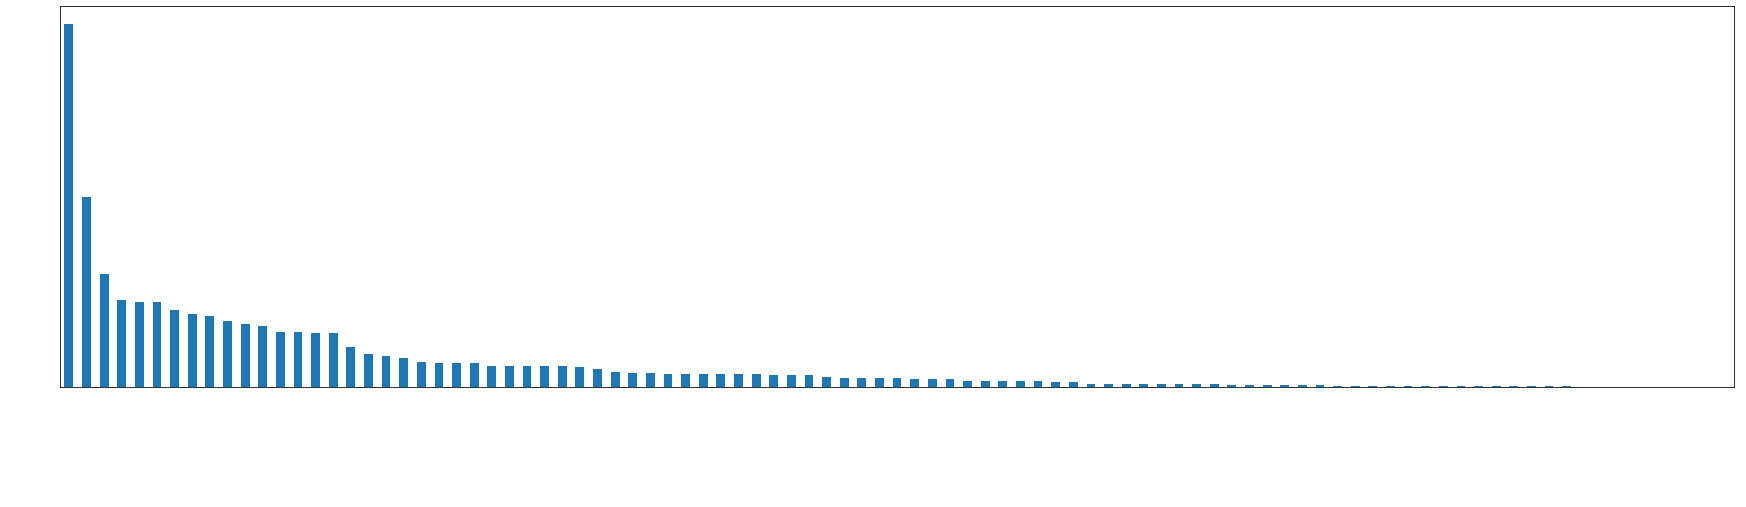

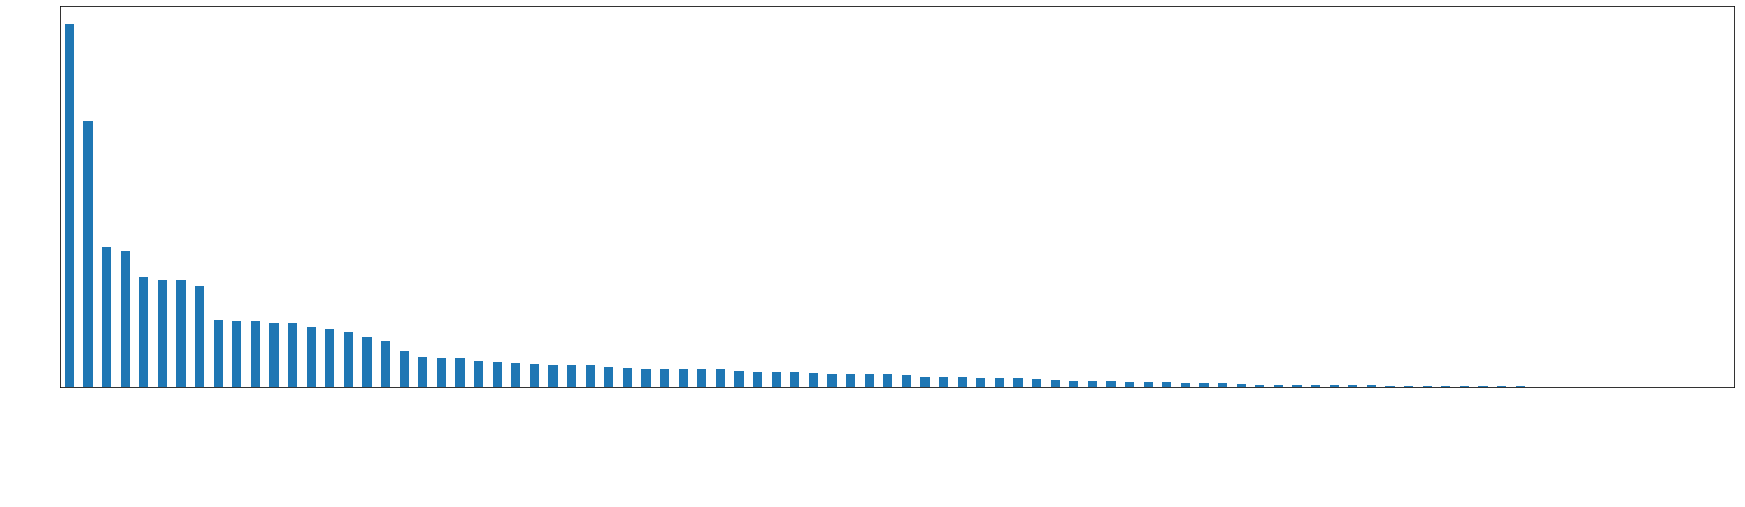

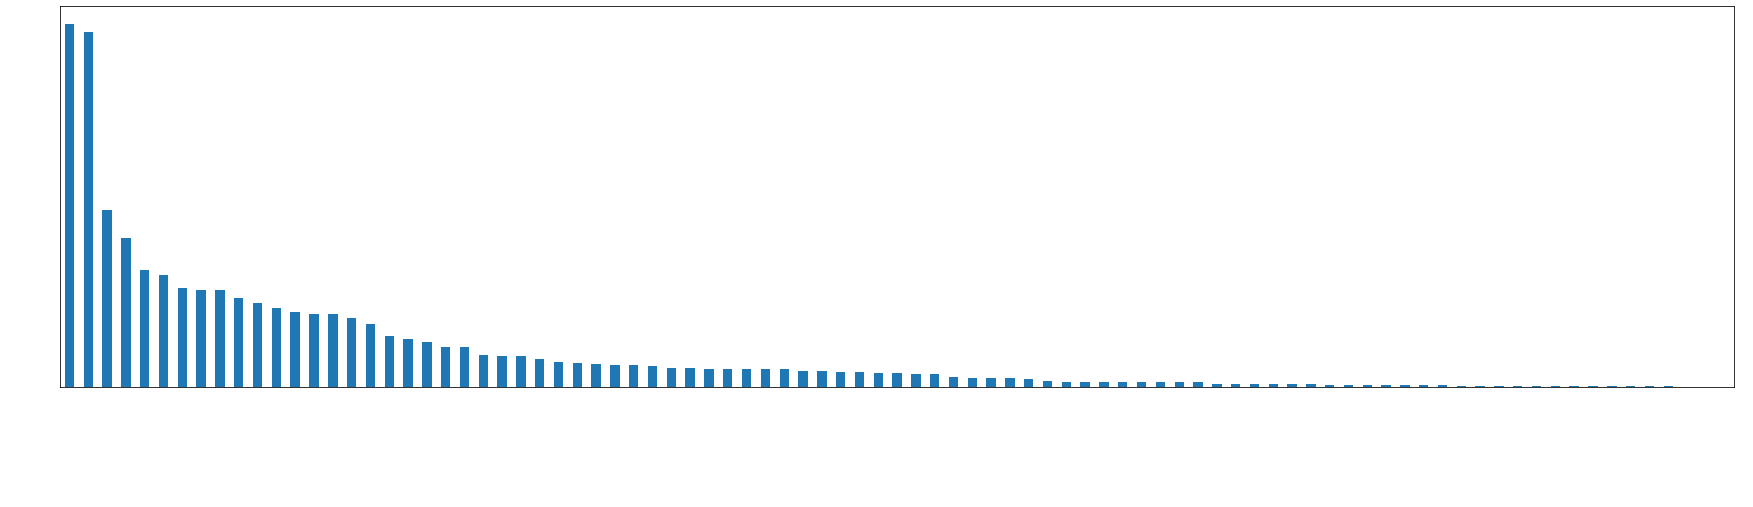

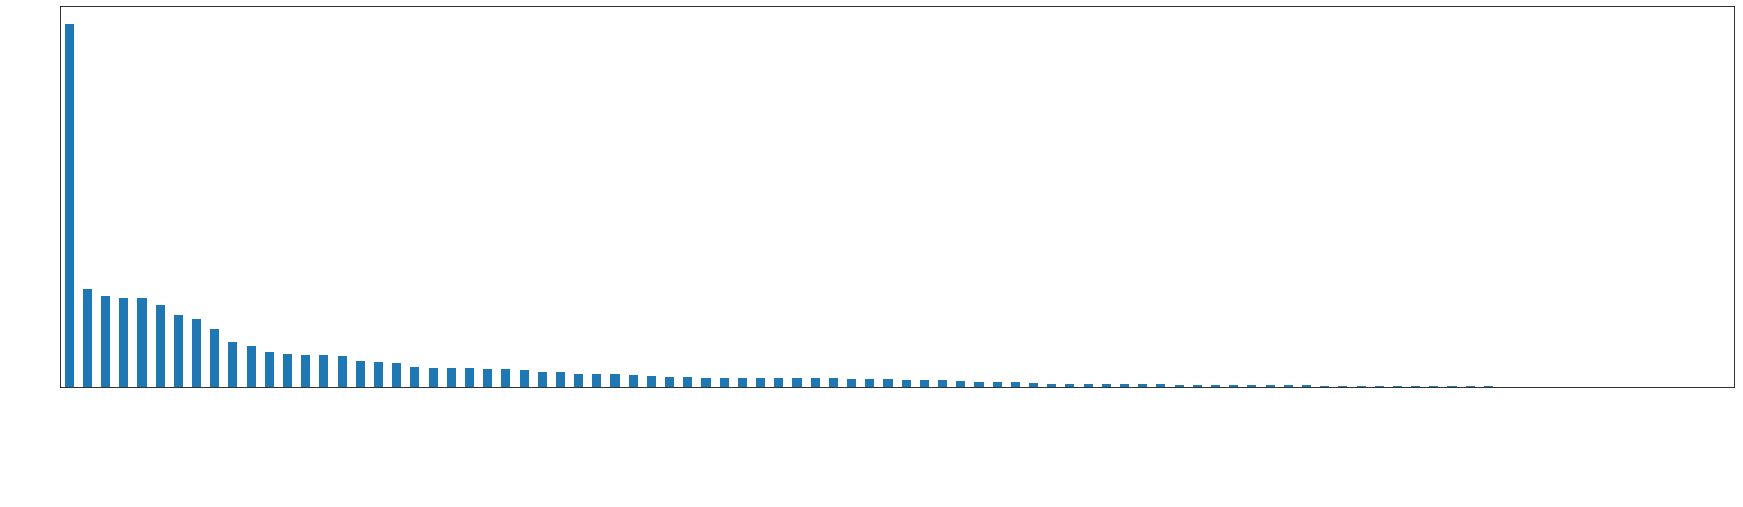

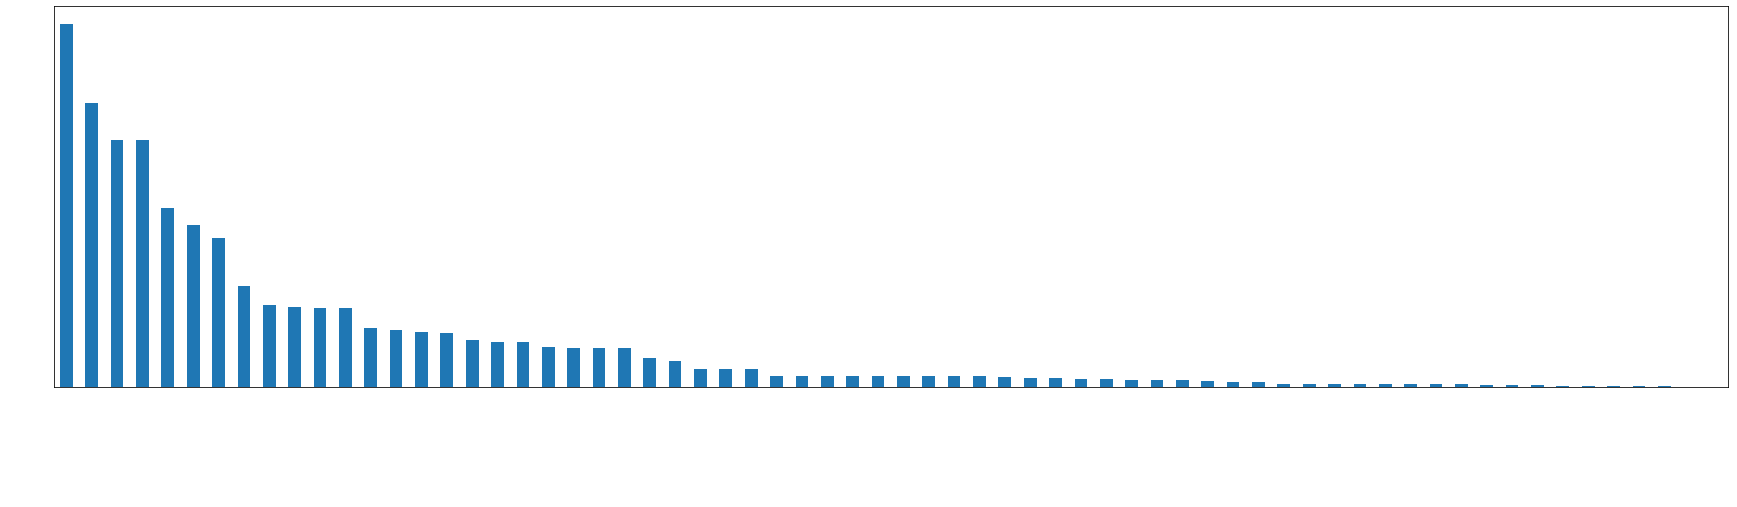

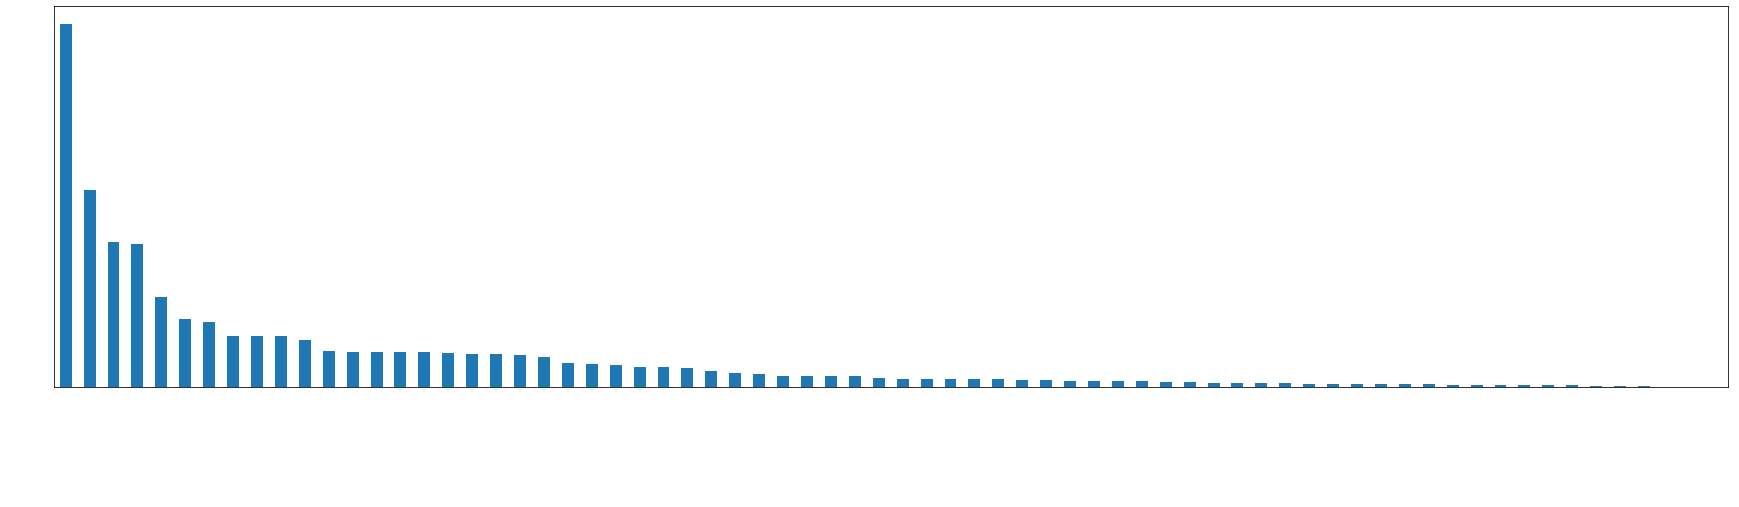

In [407]:
# Making Bar plots of restaurant types across all of NYC and each of the boroughs.
# NYC overall
plot_bar(cuisinedf['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in NYC", "Count of Restaurant")
# Brooklyn
plot_bar(cuisdf_bky['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Brooklyn", "Count of Restaurant")
# Queens
plot_bar(cuisdf_qns['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Queens", "Count of Restaurant")
# Manhattan
plot_bar(cuisdf_mh['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Manhattan", "Count of Restaurant")
# Bronx
plot_bar(cuisdf_brx['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Bronx", "Count of Restaurant")
# Staten Island
plot_bar(cuisdf_si['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Staten Island", "Count of Restaurant")

In [410]:
def dic_count_to_freq(dct):
    total = 0
    for v in dct.values():
        total += v
    for a, b in dct.items():
        dct[a] = b/total        
    return dct

In [ ]:
# dic_count_to_freq(dct)

In [413]:
def bas_word_cloud_fr_ct_dic(dct, exc = list()):
    #Makes a basic word cloud from a dictionary of counts. Optionally exclude a list of words. ############################################################################################################
    if len(exc)> 0:
        plt.imshow(WordCloud(background_color="white",width=1000,height=1000, stopwords=STOPWORDS | exc, relative_scaling=0.5).generate_from_frequencies(dct))
    else:
        plt.imshow(WordCloud(background_color="white",width=1000,height=1000, stopwords=STOPWORDS, relative_scaling=0.5).generate_from_frequencies(dct))

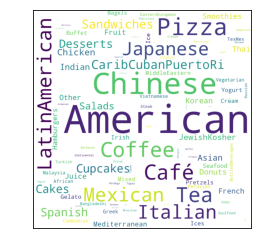

In [414]:
bas_word_cloud_fr_ct_dic(cuisine_word_setDict)

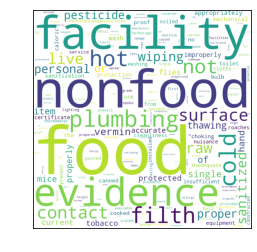

In [416]:
bas_word_cloud_fr_ct_dic(dct=violation_word_setDict, exc=violation_exclude_words)

In [417]:
type(restdata[restdata['grade']=='A']['score'].value_counts())

pandas.core.series.Series

In [418]:
restdata[restdata['grade']=='A']['score'].value_counts()

12    36869
13    29538
10    19132
11    18439
9     17089
7     13065
8      6426
5      5250
4      3845
2      3694
6      2696
3      1836
0       676
17        6
21        5
14        3
35        3
-1        2
33        2
23        1
Name: score, dtype: int64

<AxesSubplot:>

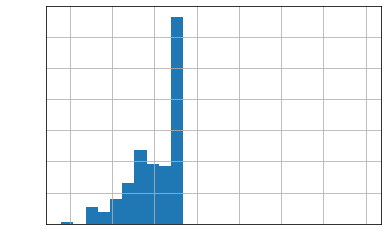

In [420]:
restdata[restdata['grade']=='A']['score'].astype(int).sort_values().hist(bins = 25)

In [186]:
restdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   camis                  20000 non-null  object
 1   dba                    19967 non-null  object
 2   boro                   20000 non-null  object
 3   building               19962 non-null  object
 4   street                 20000 non-null  object
 5   zipcode                19677 non-null  object
 6   phone                  19999 non-null  object
 7   cuisine_description    20000 non-null  object
 8   inspection_date        20000 non-null  object
 9   action                 19807 non-null  object
 10  violation_code         19581 non-null  object
 11  violation_description  19416 non-null  object
 12  critical_flag          19416 non-null  object
 13  score                  19051 non-null  object
 14  grade                  10099 non-null  object
 15  grade_date         

<AxesSubplot:>

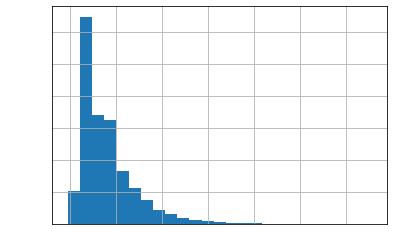

In [463]:
restdata[restdata['score'].notna()]['score'].astype(int).sort_values().hist(bins = 25)

In [ ]:
fig, ax = restdata[restdata['score'].notna()]['score'].astype(int).sort_values().hist()
ax.plt 
plt.show()

In [421]:
bkscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Brooklyn'))]['score'].astype(int).sort_values()

In [422]:
qnscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Queens'))]['score'].astype(int).sort_values()

In [423]:
mhscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Manhattan'))]['score'].astype(int).sort_values()

In [424]:
bxscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Bronx'))]['score'].astype(int).sort_values()

In [425]:
siscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Staten Island'))]['score'].astype(int).sort_values()

In [448]:
bkgv = restdata[restdata['boro'] == 'Brooklyn']['gradeval']

In [449]:
qngv = restdata[restdata['boro'] == 'Queens']['gradeval']

In [450]:
mhgv = restdata[restdata['boro'] == 'Manhattan']['gradeval']

In [451]:
bxgv = restdata[restdata['boro'] == 'Bronx']['gradeval']

In [452]:
sigv = restdata[restdata['boro'] == 'Staten Island']['gradeval']

In [427]:
stats.mannwhitneyu(bkscores, qnscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=4027761290.0, pvalue=6.279700273260612e-10)

In [428]:
stats.mannwhitneyu(bkscores, mhscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=7063251831.5, pvalue=0.07291172955343204)

In [429]:
stats.mannwhitneyu(bkscores, bxscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=1633356266.0, pvalue=0.00022866041586911854)

In [430]:
stats.mannwhitneyu(bkscores, siscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=593789637.0, pvalue=0.00021761478432325465)

In [432]:
stats.mannwhitneyu(qnscores, mhscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=6247632696.5, pvalue=5.41108915663237e-16)

In [433]:
stats.mannwhitneyu(qnscores, bxscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=1482260416.5, pvalue=0.1603084485152904)

In [434]:
stats.mannwhitneyu(qnscores, siscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=543026556.0, pvalue=0.32130699230651416)

In [435]:
stats.mannwhitneyu(mhscores, bxscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=2532442622.0, pvalue=8.385718703075684e-07)

In [436]:
stats.mannwhitneyu(mhscores, siscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=920405377.0, pvalue=6.850229586229323e-06)

In [437]:
stats.mannwhitneyu(bxscores, siscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=218545255.0, pvalue=0.14756430041731255)

In [213]:
scipy.stats.kruskal(bkscores, qnscores, nan_policy='omit')

KruskalResult(statistic=3.624829946151356, pvalue=0.05692338919576767)

In [453]:
stats.mannwhitneyu(bkgv, qngv, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=4483083938.0, pvalue=2.340965345856826e-06)

In [454]:
stats.mannwhitneyu(bkgv, mhgv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=7798981557.0, pvalue=0.002894214267661095)

In [455]:
stats.mannwhitneyu(bkgv, bxgv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=1801184452.5, pvalue=0.0005274865246170486)

In [456]:
stats.mannwhitneyu(bkgv, sigv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=653929991.0, pvalue=2.186457974405724e-07)

In [457]:
stats.mannwhitneyu(qngv, mhgv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=6966581755.0, pvalue=0.009563484151986884)

In [458]:
stats.mannwhitneyu(qngv, bxgv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=1623721612.5, pvalue=0.4237846029112684)

In [459]:
stats.mannwhitneyu(qngv, sigv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=590206408.5, pvalue=0.002910983365737641)

In [460]:
stats.mannwhitneyu(mhgv, bxgv, use_continuity=True, alternative=None) # High

MannwhitneyuResult(statistic=2799153181.0, pvalue=0.06594103012805569)

In [461]:
stats.mannwhitneyu(mhgv, sigv, use_continuity=True, alternative=None) # Low

MannwhitneyuResult(statistic=1016299684.5, pvalue=4.550274454980273e-05)

In [462]:
stats.mannwhitneyu(bxgv, sigv, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=236794559.5, pvalue=0.0035729632458150044)

In [441]:
bkscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Brooklyn'))]['score'].astype(int).sort_values()

Null no significant diff
Alt there is a sig difference

In [232]:
stats.chisquare(restdata.groupby('boro')['camis'].nunique().drop(labels='0'), f_exp=None, ddof=0, axis=0)

Power_divergenceResult(statistic=5042.013632718525, pvalue=0.0)

In [233]:
stats.chisquare(restdata.groupby('gradeval')['camis'].nunique(), f_exp=None, ddof=0, axis=0)

Power_divergenceResult(statistic=9905.7329216273, pvalue=0.0)

<AxesSubplot:title={'center':'Count of Restaurants Across the Boroughs of NYC'}, xlabel='boro'>

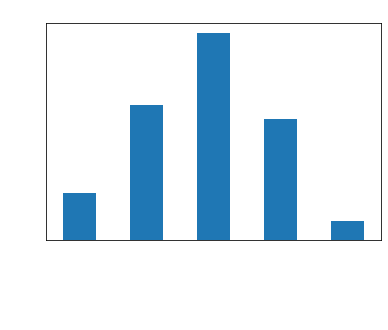

In [465]:
restdata.groupby('boro')['camis'].nunique().drop(labels='0').plot.bar(title = 'Count of Restaurants Across the Boroughs of NYC', rot=60)

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html#pandas.crosstab

In [439]:
crosstab_boro_gradeval = pd.crosstab(restdata[restdata['boro'] != '0']['boro'], restdata['gradeval'], margins=False, margins_name='All', dropna=True, normalize=False)
crosstab_boro_gradeval

gradeval,0,1,2,3
boro,,,,
Bronx,17951,1079,2885,14209
Brooklyn,51936,2362,6700,39773
Manhattan,79567,3910,9677,62530
Queens,45443,2275,5831,36404
Staten Island,6585,266,880,5568


In [438]:
pd.crosstab(restdata[restdata['boro'] != '0']['boro'], restdata['gradeval'], margins=True, margins_name='All', dropna=True, normalize=False)

gradeval,0,1,2,3,All
boro,,,,,
Bronx,17951,1079,2885,14209,36124
Brooklyn,51936,2362,6700,39773,100771
Manhattan,79567,3910,9677,62530,155684
Queens,45443,2275,5831,36404,89953
Staten Island,6585,266,880,5568,13299
All,201482,9892,25973,158484,395831


In [362]:
stats.chisquare(crosstab_boro_gradeval, f_exp=None, ddof=0, axis=0)

Power_divergenceResult(statistic=array([4036.01082677,  184.42910448,  502.28254438, 3214.88598037]), pvalue=array([0.0000000e+000, 8.3408926e-039, 2.1496871e-107, 0.0000000e+000]))